In [2]:
from kaggle_secrets import UserSecretsClient

token = UserSecretsClient().get_secret("Token")

! git clone https://{token}@github.com/madratak/RECsys_Challenge2024.git

Cloning into 'RECsys_Challenge2024'...
remote: Enumerating objects: 2511, done.
remote: Counting objects: 100% (893/893), done.
remote: Compressing objects: 100% (391/391), done.
remote: Total 2511 (delta 560), reused 754 (delta 465), pack-reused 1618 (from 1)
Receiving objects: 100% (2511/2511), 150.21 MiB | 32.09 MiB/s, done.
Resolving deltas: 100% (1505/1505), done.


In [3]:
! pip install PyGithub requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.9/375.9 kB 6.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 23.6 MB/s eta 0:00:0000:01


In [4]:
%cd /kaggle/working/RECsys_Challenge2024
! python run_compile_all_cython.py

/kaggle/working/RECsys_Challenge2024
run_compile_all_cython: Found 11 Cython files in 5 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/11]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorization_Cython_Epoch.c:1252:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorization_Cython_Epoch.c: In fun

In [5]:
from Utils.notebookFunctions import *
import numpy as np
import pandas as pd
import scipy.sparse as sps
import time
import shutil
import optuna
import json
import os
from Utils.seconds_to_biggest_unit import seconds_to_biggest_unit


K_PATH = '/kaggle/working/RecSys_Challenge2024'
GH_PATH = 'TrainedModels/WithoutKFCV/' # add class of recommender type

np.random.seed(42)
repo = get_repo_from_github(token)

config = {
    'model': 'SLIMElasticNet-ss54',
    'tune_parameters': True,
    'database_path': '/kaggle/working/history_SLIMElasticNet_ss60.db',
    'copy_prev_best_params': False,
    'tune_best_params': True,
    'save_github': True
}

Repository 'RECsys_Challenge2024' found.


In [11]:

# Define the function to upload files to GitHub
def upload_file_2(filepath_kaggle, filepath_github, commit_message, repo_name, github_token):
    """
    Uploads a file from Kaggle to GitHub, updating it if it already exists or creating it otherwise.
    
    Parameters:
    - filepath_kaggle: Path to the file in the Kaggle environment.
    - filepath_github: Target path in the GitHub repository.
    - commit_message: Commit message for the GitHub update/create action.
    - repo_name: Name of the GitHub repository (e.g., "username/repository").
    - github_token: Personal Access Token for authenticating with GitHub.
    """
    try:
        # Authenticate with GitHub
        g = Github(github_token)
        repo = g.get_repo(repo_name)

        # Check if the file already exists in the repo
        try:
            contents = repo.get_contents(filepath_github)
            
            # Update the file if it exists
            with open(filepath_kaggle, "rb") as file:
                repo.update_file(contents.path, commit_message, file.read(), contents.sha)
            print(f"File '{filepath_github}' updated successfully.")

        except Exception as e:
            # If the file does not exist, create it
            with open(filepath_kaggle, "rb") as file:
                repo.create_file(filepath_github, commit_message, file.read())
            print(f"File '{filepath_github}' created successfully.")

    except Exception as e:
        print(f"An error occurred: {e}")

    

In [6]:
URM_all_dataframe = pd.read_csv("/kaggle/working/RECsys_Challenge2024/Dataset/data_train.csv")

n_users = len(URM_all_dataframe["user_id"].unique())
n_items = len(URM_all_dataframe["item_id"].unique())

URM_all = sps.csr_matrix((URM_all_dataframe["data"].values, 
                          (URM_all_dataframe["user_id"].values, URM_all_dataframe["item_id"].values)),
                        shape = (n_users, n_items))

from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 141 ( 0.4%) Users that have less than 1 test interactions


In [7]:
URM_validation

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 352921 stored elements and shape (35736, 38121)>

## Splitting validation dataset 

In [23]:
import numpy as np
import pandas as pd
from github import Github
import os

# Step 1: Calculate interaction counts for each user
user_interaction_counts = np.diff(URM_validation.indptr)  # Interaction counts for each user

# Step 2: Sort users by interaction counts
sorted_user_indices = np.argsort(user_interaction_counts)  # Indices of users sorted by interaction counts

# Step 3: Determine group sizes
n_groups = 5  # Number of groups you want
n_users = len(sorted_user_indices)
users_per_group = n_users // n_groups
remaining_users = n_users % n_groups  # Number of users that cannot be evenly distributed

# Step 4: Split users into groups and save as CSV files
csv_filepaths = []  # Store file paths to upload to GitHub

start_idx = 0
for group_id in range(n_groups):
    # Distribute the remaining users to the first `remaining_users` groups
    extra_user = 1 if group_id < remaining_users else 0
    end_idx = start_idx + users_per_group + extra_user  # Adjust end index for the group
    
    group_user_indices = sorted_user_indices[start_idx:end_idx]  # Get user IDs in the group
    group_data = pd.DataFrame({
        "user_id": group_user_indices,
        "interaction_count": user_interaction_counts[group_user_indices]
    })
    
    # Save to CSV file
    csv_filename = f"group_{group_id}.csv"
    group_data.to_csv(csv_filename, index=False)
    csv_filepaths.append(csv_filename)  # Keep track of files
    print(f"Group {group_id}: Saved {len(group_user_indices)} users to {csv_filename}")
    
    # Update start_idx for the next group
    start_idx = end_idx


Group 0: Saved 7148 users to group_0.csv
Group 1: Saved 7147 users to group_1.csv
Group 2: Saved 7147 users to group_2.csv
Group 3: Saved 7147 users to group_3.csv
Group 4: Saved 7147 users to group_4.csv


In [24]:
# Step 6: Upload files to GitHub
# Replace these with your GitHub details
repo_name = "madratak/RECsys_Challenge2024"
github_token = UserSecretsClient().get_secret("Token")
commit_message = "Added grouped user (validation) interaction files"

for filepath in csv_filepaths:
    filepath_github = f"splitted_datasets/validation/{os.path.basename(filepath)}"  # Path in the GitHub repo
    upload_file_2(filepath, filepath_github, commit_message, repo_name, github_token)

File 'splitted_datasets/validation/group_0.csv' updated successfully.
File 'splitted_datasets/validation/group_1.csv' updated successfully.
File 'splitted_datasets/validation/group_2.csv' updated successfully.
File 'splitted_datasets/validation/group_3.csv' updated successfully.
File 'splitted_datasets/validation/group_4.csv' created successfully.


## Splitting target dataset 

In [25]:
group_number = 5

# Load datasets
data_train = pd.read_csv("/kaggle/working/RECsys_Challenge2024/Dataset/data_train.csv")
data_target_users = pd.read_csv("/kaggle/working/RECsys_Challenge2024/Dataset/data_target_users_test.csv")

# Step 2: Count interactions for each user
user_interactions = data_train.groupby("user_id").size().reset_index(name="interaction_count")

# Step 3: Filter for target users
target_user_interactions = user_interactions[user_interactions["user_id"].isin(data_target_users["user_id"])].copy()

# Step 4: Sort by interaction count
target_user_interactions = target_user_interactions.sort_values("interaction_count").reset_index(drop=True)

# Step 5: Divide into 5 approximately equal groups
n_users = len(target_user_interactions)
group_size = n_users // group_number  # Number of users in each group
remainder = n_users % group_number    # Handle uneven divisions

groups = []
# Assign users to groups
start = 0
for i in range(group_number):
    end = start + group_size + (1 if i < remainder else 0)  # Distribute remainder across first groups
    groups.append(target_user_interactions.iloc[start:end])
    
    start = end

csv_filepaths = []
# Step 6: Save or display groups
for i, group in enumerate(groups, start=1):
    group.to_csv(f"group_{i}.csv", index=False)
    print(f"Group {i} has {len(group)} users.")
    csv_filepaths.append(f"group_{i}.csv")  # Keep track of files


Group 1 has 6847 users.
Group 2 has 6846 users.
Group 3 has 6846 users.
Group 4 has 6846 users.
Group 5 has 6846 users.


In [26]:
# Step 6: Upload files to GitHub
# Replace these with your GitHub details
repo_name = "madratak/RECsys_Challenge2024"
github_token = UserSecretsClient().get_secret("Token")
commit_message = "Added grouped user(target) interaction files"

for filepath in csv_filepaths:
    filepath_github = f"splitted_datasets/target/{os.path.basename(filepath)}"  # Path in the GitHub repo
    upload_file_2(filepath, filepath_github, commit_message, repo_name, github_token)

File 'splitted_datasets/target/group_1.csv' created successfully.
File 'splitted_datasets/target/group_2.csv' created successfully.
File 'splitted_datasets/target/group_3.csv' created successfully.
File 'splitted_datasets/target/group_4.csv' created successfully.
File 'splitted_datasets/target/group_5.csv' created successfully.


## Plotting box-plot of each group

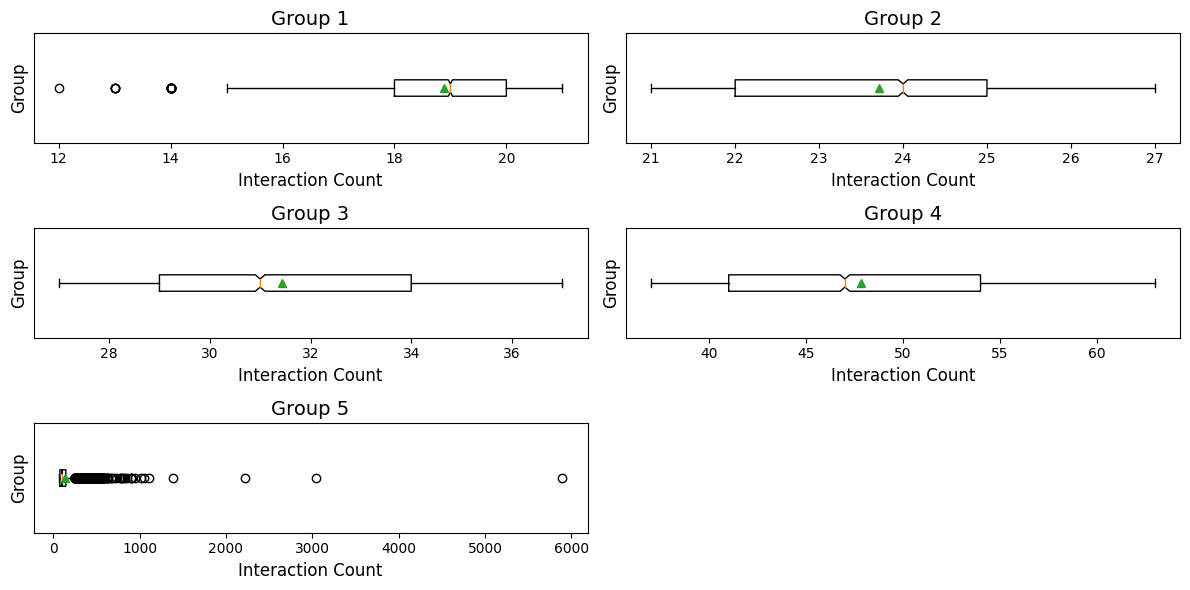

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the groups from the previous code
groups = []
for i in range(1, group_number+1):
    group = pd.read_csv(f"group_{i}.csv")
    groups.append(group)

# Create subplots for the box plots
fig, axes = plt.subplots(3, 2, figsize=(12, 6))  # 2 columns, 3 rows
axes = axes.flatten()  # Flatten to make it easier to index

# Plot each group with horizontal orientation
for i, group in enumerate(groups):
    axes[i].boxplot(group["interaction_count"], notch=True, showmeans=True, vert=False)  # Horizontal boxplot
    axes[i].set_title(f"Group {i+1}", fontsize=14)
    axes[i].set_xlabel("Interaction Count", fontsize=12)
    axes[i].set_ylabel("Group", fontsize=12)
    axes[i].set_yticks([])  # Remove y-axis ticks for simplicity

# Remove empty subplot (since we have only 5 plots)
if len(groups) < len(axes):
    for j in range(len(groups), len(axes)):
        fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()
